In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/My\ Drive/av-photos.zip -d train

# Load previous train model for refusing training
# !cp -q /content/gdrive/My\ Drive/FN-EfficientNet-b5.tar prev_model

In [4]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Sep 16 12:00:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [5]:
import json
import pickle
import os
import time
import copy
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

DEVICE = torch.device("cuda")

In [6]:
class CarDataset(Dataset):
    """
    A dataset with pictures, which parallel loads them from folders,
    scans and turns them into end tensors
    """
    def __init__(self, files):
        super().__init__()
        # file list for loading
        self.files = sorted(files)

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()
            
        # create label for image  
        self.labels = [ " ".join([path.parent.parent.name, path.parent.name]) for path in self.files]
        self.label_encoder.fit(self.labels)

        with open('label_encoder.pkl', 'wb') as le_dump_file:
              pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):
        # tarnsform image to pytorch tensor
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        return x, y

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """
    Function for print image with their label
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
TRAIN_DIR = Path('train/av-photos')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [9]:
from sklearn.model_selection import train_test_split

train_val_labels = [ " ".join([path.parent.parent.name, path.parent.name]) for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [10]:
val_dataset = CarDataset(val_files)
train_dataset = CarDataset(train_files)

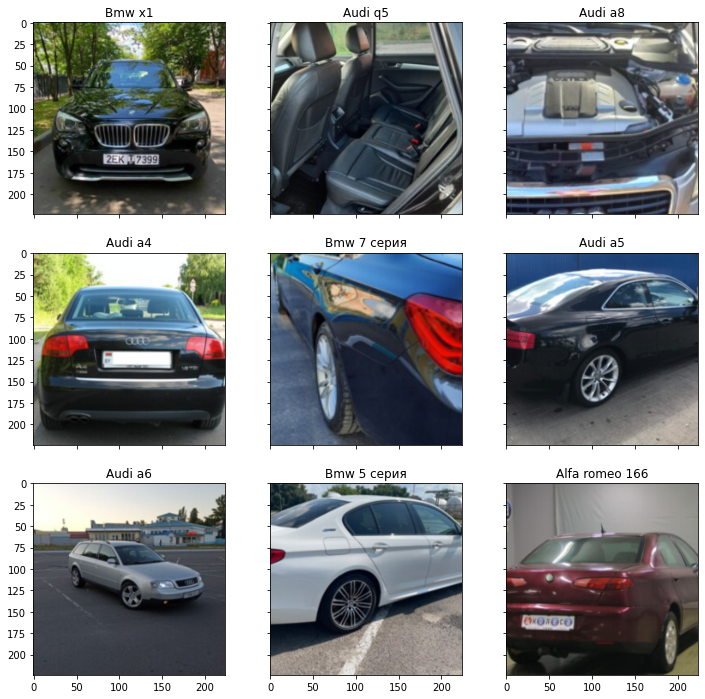

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,10000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [12]:
BATCH_SIZE = 32
CLASS_NUM = 0
NUM_EPOCHS = 5
feature_extract = True
# checkpoint = torch.load('prev_model')

train_folder = 'train/av-photos'
for brand in os.listdir(train_folder):
  if brand.endswith('.ipynb_checkpoints'):
    continue
  brand_folder = os.path.join(train_folder, brand)
  brand_count = len(os.listdir(brand_folder))
  CLASS_NUM += brand_count


In [25]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet.classifier.fc = torch.nn.Linear(in_features=efficientnet.classifier.fc.in_features, out_features=CLASS_NUM)

# Load under-train model
# efficientnet.load_state_dict(checkpoint['model_state_dict'])

Sequential(
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (squeeze): Flatten()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1280, out_features=1000, bias=True)
)
Sequential(
  (pooling): AdaptiveAvgPool2d(output_size=1)
  (squeeze): Flatten()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=1280, out_features=567, bias=True)
)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [26]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [27]:
# Send the model to GPU
model_ft = efficientnet.to(DEVICE)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# efficientnet.load_state_dict(checkpoint['optimizer_state_dict'])

Params to learn:
	 stem.conv.weight
	 stem.bn.weight
	 stem.bn.bias
	 layers.0.block0.depsep.conv.weight
	 layers.0.block0.depsep.bn.weight
	 layers.0.block0.depsep.bn.bias
	 layers.0.block0.se.squeeze.weight
	 layers.0.block0.se.squeeze.bias
	 layers.0.block0.se.expand.weight
	 layers.0.block0.se.expand.bias
	 layers.0.block0.proj.conv.weight
	 layers.0.block0.proj.bn.weight
	 layers.0.block0.proj.bn.bias
	 layers.1.block0.expand.conv.weight
	 layers.1.block0.expand.bn.weight
	 layers.1.block0.expand.bn.bias
	 layers.1.block0.depsep.conv.weight
	 layers.1.block0.depsep.bn.weight
	 layers.1.block0.depsep.bn.bias
	 layers.1.block0.se.squeeze.weight
	 layers.1.block0.se.squeeze.bias
	 layers.1.block0.se.expand.weight
	 layers.1.block0.se.expand.bias
	 layers.1.block0.proj.conv.weight
	 layers.1.block0.proj.bn.weight
	 layers.1.block0.proj.bn.bias
	 layers.1.block1.expand.conv.weight
	 layers.1.block1.expand.bn.weight
	 layers.1.block1.expand.bn.bias
	 layers.1.block1.depsep.conv.weight
	

In [28]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_worker=1)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_worker=1)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader
dataloaders_dict['val'] = val_loader

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_hist, train_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=NUM_EPOCHS)

Epoch 0/19
----------
train Loss: 5.2238 Acc: 0.0757
val Loss: 4.4419 Acc: 0.1448

Epoch 1/19
----------
train Loss: 4.0185 Acc: 0.1956
val Loss: 3.5165 Acc: 0.2647

Epoch 2/19
----------
train Loss: 3.2536 Acc: 0.3069
val Loss: 2.8780 Acc: 0.3700

Epoch 3/19
----------
train Loss: 2.6937 Acc: 0.4031
val Loss: 2.4234 Acc: 0.4515

Epoch 4/19
----------
train Loss: 2.2754 Acc: 0.4812
val Loss: 2.1242 Acc: 0.5103

Epoch 5/19
----------


In [ ]:
# Save under-training model because of Google Colab limits, and then refusing training again.
torch.save({'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict()},
           'FN-EfficientNet-b5.tar')

acc_history = {}
acc_history['val'] = val_hist
acc_history['train'] = train_hist

# Save accuracy from this training loop
with open('acc_history.json', 'w') as f:
    json.dump(acc_history, f)